# CS 179 Project

In [75]:
import pyGM as gm
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from pyGM.messagepass import LBP, NMF
import pickle

# Load training data and reduce (subsample) if desired

# Read thru file to get numeric ids for each player 
with open('train.csv') as f: lines = f.read().split('\n')
with open('valid.csv') as f: lines2 = f.read().split('\n')
    
p = 0; playerid = {};
for i in range(len(lines)):
  csv = lines[i].split(',');
  if len(csv) != 10: continue;   # parse error or blank line
  player0,player1 = csv[1],csv[4];
  if player0 not in playerid: playerid[player0]=p; p+=1;
  if player1 not in playerid: playerid[player1]=p; p+=1;

nplayers = len(playerid)
playername = ['']*nplayers
for player in playerid: playername[ playerid[player] ]=player;  # id to name lookup

# Do we need this part?
# # Sparsifying parameters (discard some training examples):
# pKeep = 1.0   # fraction of edges to consider (immed. throw out 1-p edges)
# nEdge = 3     # try to keep nEdge opponents per player (may be more; asymmetric)
# nKeep = 5     # keep at most nKeep games per opponent pairs (play each other multiple times)

# nplays, nwins = np.zeros( (nplayers,nplayers) ), np.zeros( (nplayers,nplayers) );
# for i in range(len(lines)):
#   csv = lines[i].split(',');
#   if len(csv) != 10: continue;   # parse error or blank line
#   a,b = playerid[csv[1]],playerid[csv[4]];
#   aw,bw = csv[2]=='[winner]',csv[5]=='[winner]';
#   if (np.random.rand() < pKeep):
#     if (nplays[a,b] < nKeep) and ( ((nplays[a,:]>0).sum() < nEdge) or ((nplays[:,b]>0).sum() < nEdge) ):
#       nplays[a,b] += 1; nplays[b,a]+=1; nwins[a,b] += aw; nwins[b,a] += bw;

In [56]:
nlevels = 15
scale = 0.3

X = [None]*nplayers
for i in range(nplayers):
    X[i] = gm.Var(i, nlevels)

Pwin = np.zeros( (nlevels,nlevels) )
for i in range(nlevels):
    for j in range(nlevels):
        diff = i-j
        Pwin[i,j] = (1.0/(1+np.exp(-scale*diff)))

factors = [ gm.Factor([X[i]], 1.0/nlevels) for i in range(nplayers) ]
pKeep = 0.15  # keep a fraction of the 193k games

for i in range(len(lines)):
    csv = lines[i].split(',')
    if len(csv) != 10: continue
    P1,P2 = playerid[csv[1]],playerid[csv[4]]
    win = -1
    if csv[2]=='[winner]':
        win = 1
    if P1>P2: P1,P2,win=P2,P1,-win
    if P1 != P2 and np.random.rand() < pKeep:
        factors.append(gm.Factor([X[P1],X[P2]], Pwin if win>0 else 1-Pwin) )

In [51]:
model = gm.GraphModel(factors)
model.makeMinimal()

In [ ]:
# This one gives an error
#lnZ, bel = LBP(model, maxIter=10, verbose=True)

In [52]:
lnZ, bel = NMF(model, maxIter=5, verbose=True)

Iter 0: -19626.42752229488
Iter 1: -12382.013424465491
Iter 2: -12117.559427115173
Iter 3: -12048.03565904315
Iter 4: -12029.381819168568
Iter 5: -12023.438579345218


In [53]:
totalGames = 0
correctlyPredictedGames = 0

for i in range(len(lines2)):
    csv = lines2[i].split(',')
    if len(csv) != 10: continue
    P1,P2 = playerid[csv[1]],playerid[csv[4]]
    win = -1
    if csv[2]=='[winner]':
        win = 1
    if P1>P2: P1,P2,win=P2,P1,-win
    if P1 != P2:
        totalGames += 1
        predictedWin = (bel[P1]*bel[P2]*gm.Factor([X[P1],X[P2]],Pwin)).table.sum()
        if((predictedWin > 0.5 and win == 1) or (predictedWin < 0.5 and win == -1)):
            correctlyPredictedGames += 1

In [54]:
print(correctlyPredictedGames / totalGames)

0.6634399565989767


In [60]:
levels = []
for i in range(nplayers):
    #levels.append(bel[i].table.dot(np.arange(nlevels)))
    print(bel[i].table.dot(np.arange(nlevels)))

levels.sort(reverse=True)
print(levels)
#print([ bel[i].table.dot(np.arange(nlevels)) for i in range(nplayers)] )

11.45246933528267
13.901217731493475
13.87644059527208
13.958114417600678
11.84562711821033
11.593278627148774
11.925303657287241
12.381546256609457
13.806022925721825
13.368981275515614
9.529570347158312
11.188266024033972
11.593271124951901
12.417195609664104
12.50996505141341
8.86473912469432
7.035406406872794
6.848914617144409
10.854802026021574
10.913527128900501
10.318852923279275
10.153759966881651
11.640403885267716
10.258214752157707
12.760545023168937
12.10375334878936
11.793959284247784
10.888442240217781
10.180204159402075
9.57567142841778
13.17622890973107
5.2247179909810795
10.958807518926289
12.190093676457924
12.509803429178413
11.814119675166385
11.291164915040756
11.813992458404586
13.886122297826372
12.532252566366873
8.331837118502003
12.156520148229136
13.045839190112826
13.881632808234595
9.01164704806114
13.87430861826277
12.875693327646859
11.489898466647729
13.349936427322072
13.82687012834007
8.488254878444886
9.033246691543944
6.866817392165538
9.530880010696

In [85]:
#Testing multiple percentage of games kept
#This will calculate skill level and number of correctly predicted games
emptyList = []
with open('data.pickle', 'wb') as handle:
        pickle.dump(emptyList, handle)

pKeepList = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.20]
for n in pKeepList:
    
    nlevels = 15
    scale = 0.3

    X = [None]*nplayers
    for i in range(nplayers):
        X[i] = gm.Var(i, nlevels)

    Pwin = np.zeros( (nlevels,nlevels) )
    for i in range(nlevels):
        for j in range(nlevels):
            diff = i-j
            Pwin[i,j] = (1.0/(1+np.exp(-scale*diff)))
            
    factors = [ gm.Factor([X[i]], 1.0/nlevels) for i in range(nplayers) ]
    
    for i in range(len(lines)):
        csv = lines[i].split(',')
        if len(csv) != 10: continue
        P1,P2 = playerid[csv[1]],playerid[csv[4]]
        win = -1
        if csv[2]=='[winner]':
            win = 1
        if P1>P2: P1,P2,win=P2,P1,-win
        if P1 != P2 and np.random.rand() < n:
            factors.append(gm.Factor([X[P1],X[P2]], Pwin if win>0 else 1-Pwin) )
        
    model = gm.GraphModel(factors)
    model.makeMinimal()
    
    lnZ, bel = NMF(model, maxIter=5, verbose=True)
    
    totalGames = 0
    correctlyPredictedGames = 0

    for i in range(len(lines2)):
        csv = lines2[i].split(',')
        if len(csv) != 10: continue
        P1,P2 = playerid[csv[1]],playerid[csv[4]]
        win = -1
        if csv[2]=='[winner]':
            win = 1
        if P1>P2: P1,P2,win=P2,P1,-win
        if P1 != P2:
            totalGames += 1
            predictedWin = (bel[P1]*bel[P2]*gm.Factor([X[P1],X[P2]],Pwin)).table.sum()
            if((predictedWin > 0.5 and win == 1) or (predictedWin < 0.5 and win == -1)):
                correctlyPredictedGames += 1
                
    pCorrect = correctlyPredictedGames / totalGames
    print(pCorrect)
    
    levels = {}
    for i in range(nplayers):
        levels[playername[i]] = bel[i].table.dot(np.arange(nlevels))
        #print(bel[i].table.dot(np.arange(nlevels)))
        
    data = {'pKeep': n, 'pPredicted': pCorrect, 'SkillLevel': levels}
    with open('data.pickle', 'rb') as handle:
        dataList = pickle.load(handle)
        
    dataList.append(data)
    with open('data.pickle', 'wb') as handle:
        pickle.dump(dataList, handle)


Iter 0: -2080.579916724659
Iter 1: -1445.4464324920007
Iter 2: -1428.163457057124
Iter 3: -1427.0279529191541
Iter 4: -1426.8487099069405
Iter 5: -1426.8102476975544
0.5925941685193655
Iter 0: -4950.486896084444
Iter 1: -3342.623718320578
Iter 2: -3273.606716870852
Iter 3: -3262.096880248139
Iter 4: -3259.705642513268
Iter 5: -3259.0142191738137
0.6246981607752614
Iter 0: -9948.189715290662
Iter 1: -6489.036288540612
Iter 2: -6354.748993669385
Iter 3: -6325.466392559937
Iter 4: -6318.3261718966005
Iter 5: -6315.921145240176
0.6481751358941356
Iter 0: -14880.200815370337
Iter 1: -9495.401572332563
Iter 2: -9292.315193755952
Iter 3: -9251.148959767783
Iter 4: -9242.39994814079
Iter 5: -9239.920320928324
0.6575255034199581
Iter 0: -19845.057775014233
Iter 1: -12603.98893453037
Iter 2: -12335.881792428228
Iter 3: -12264.334363115131
Iter 4: -12241.600090008067
Iter 5: -12232.307795227856
0.6651845075366728
Iter 0: -24672.3726977341
Iter 1: -15431.209723271377
Iter 2: -15087.664632452877
It

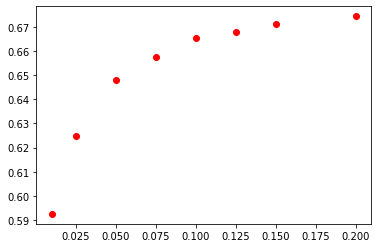

In [93]:
with open('data.pickle', 'rb') as handle:
    dataList = pickle.load(handle)

pKeep = []
pPredicted = []
for i in range(len(dataList)):
    pKeep.append(dataList[i]['pKeep'])
    pPredicted.append(dataList[i]['pPredicted'])
    
plt.plot(pKeep, pPredicted, 'ro')
plt.show()